Stages:

A. Fetch and process data

B. Define initial model

C-1. Tuning hyperparameters 1

D-1. Selecting features 1

C-2. Tuning hyperparameters 2

D-2. Selecting features 2

E. Training final model and saving output

F. Refitting test data with smaller learning rate hyperparameter

A. Fetch and process data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.base import clone
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from  helper_functions_training import *

In [5]:
#load training data
raw_train_df = pd.read_csv('train_house_final.csv')

#Numerically encode categorical features
train_df_encode = encode_categories(raw_train_df)

#Split train dataset into X (features) and y (targets)
X_train_all = train_df_encode.drop('Price', axis=1)
y_train_all = train_df_encode['Price']

#Split train data into train and validate subsets
df_train, df_validate = train_test_split(train_df_encode, random_state=89)

#split train and validate subsets into X and y
X_train = df_train.drop('Price', axis=1)
y_train = df_train['Price']
X_validate = df_validate.drop('Price', axis=1)
y_validate = df_validate['Price']

X_train_all.shape, y_train_all.shape, X_train.shape, y_train.shape, X_validate.shape, y_validate.shape

((2832894, 19), (2832894,), (2124670, 19), (2124670,), (708224, 19), (708224,))

B. Define initial model

In [8]:
#Defining pipeline for linear model

#Pipeline for X
X_pipeline = Pipeline([('log_transform', LogTransformer()),
                       ('scaler', StandardScaler()),
                       ('regressor', HistGradientBoostingRegressor(random_state=89))])
#Pipeline including log of y
grad_boost_model_pipeline = TransformedTargetRegressor(regressor = X_pipeline,
                                             transformer = ConditionalLogTransformer())

C-1. Tuning hyperparameters 1

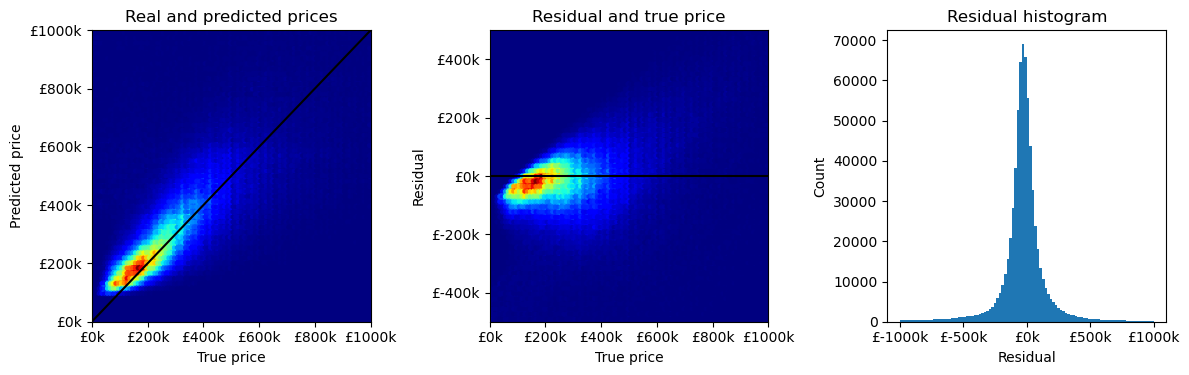

R² = 0.119


In [13]:
#Initial model fit
model_1 = clone(grad_boost_model_pipeline)
model_1.fit(X_train, y_train)
y_validate_predict = model_1.predict(X_validate)
assess_predict(y_validate, y_validate_predict)

In [20]:
#Initially tuning learning rate
param_grid_1 = {'regressor__regressor__learning_rate': [0.01, 0.05, 0.1, 0.5, 1]}

grid_search = GridSearchCV(
    model_1,
    param_grid_1,
    cv=3,
    scoring='r2',
    n_jobs=-1)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('log_transform',
                                                                             LogTransformer()),
                                                                            ('scaler',
                                                                             StandardScaler()),
                                                                            ('regressor',
                                                                             HistGradientBoostingRegressor(random_state=89))]),
                                                  transformer=ConditionalLogTransformer()),
             n_jobs=-1,
             param_grid={'regressor__regressor__learning_rate': [0.01, 0.05,
                                                                 0.1, 0.5, 1]},
             scoring='r2')

In [21]:
# Get the mean R² score for each parameter
r2_scores = grid_search.cv_results_['mean_test_score']
params = grid_search.cv_results_['params']
for param, score in zip(params, r2_scores):
    print(f"Parameters: {param}: R2 Score={score:.3f}")
#Optimal learn rate is 0.1 (the default)

Parameters: {'regressor__regressor__learning_rate': 0.01}: R2 Score=0.078
Parameters: {'regressor__regressor__learning_rate': 0.05}: R2 Score=0.122
Parameters: {'regressor__regressor__learning_rate': 0.1}: R2 Score=0.132
Parameters: {'regressor__regressor__learning_rate': 0.5}: R2 Score=0.093
Parameters: {'regressor__regressor__learning_rate': 1}: R2 Score=0.014


In [23]:
#Now tuning the other important hyperparameters
param_grid_2 = {
    'regressor__regressor__max_iter': [100, 200, 500],
    'regressor__regressor__max_depth': [5, 7, 10, None],
    'regressor__regressor__min_samples_leaf': [20, 50, 100],
    'regressor__regressor__l2_regularization': [0, 1, 5],
    'regressor__log_transform__log_income': [True, False],
    'regressor__log_transform__log_listings': [True, False],
    'transformer__log_target': [True, False],
}

random_search = RandomizedSearchCV(
    model_1,
    param_grid_2,
    cv=3,
    scoring='r2',
    n_iter=100, #About 10% of sample space
    random_state=89,
    n_jobs=-1)

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('log_transform',
                                                                                   LogTransformer()),
                                                                                  ('scaler',
                                                                                   StandardScaler()),
                                                                                  ('regressor',
                                                                                   HistGradientBoostingRegressor(random_state=89))]),
                                                        transformer=ConditionalLogTransformer()),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'regressor__log_transform__log_income': [True,
                                                                                 False],
                                        'regressor__log_transform__log_listings': [True,
                                                                                   False],
                                        'regressor__regressor__l2_regularization': [0,
                                                                                    1,
                                                                                    5],
                                        'regressor__regressor__max_depth': [5,
                                                                            7,
                                                                            10,
                                                                            None],
                                        'regressor__regressor__max_iter': [100,
                                                                           200,
                                                                           500],
                                        'regressor__regressor__min_samples_leaf': [20,
                                                                                   50,
                                                                                   100],
                                        'transformer__log_target': [True,
                                                                    False]},
                   random_state=89, scoring='r2')

In [24]:
print("Best parameters:", random_search.best_params_)

Best parameters: {'transformer__log_target': False, 'regressor__regressor__min_samples_leaf': 20, 'regressor__regressor__max_iter': 500, 'regressor__regressor__max_depth': None, 'regressor__regressor__l2_regularization': 1, 'regressor__log_transform__log_listings': True, 'regressor__log_transform__log_income': True}


D-1. Selecting features 1

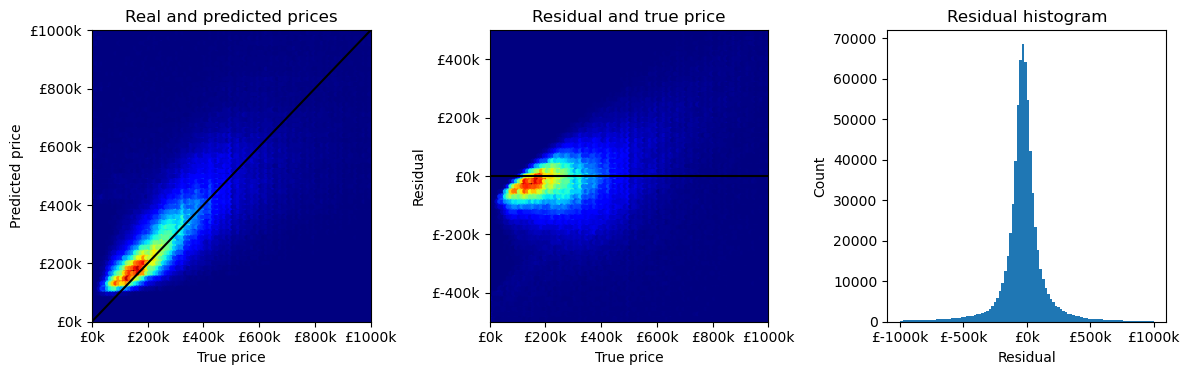

R² = 0.124


In [25]:
#fit with updated hyperparameters
model_2 = clone(grad_boost_model_pipeline).set_params(
    regressor__regressor__max_iter=500,
    regressor__regressor__l2_regularization=1,
    regressor__log_transform__log_listings=True,
    regressor__log_transform__log_income=True
)

model_2.fit(X_train, y_train)
y_validate_predict = model_2.predict(X_validate)
assess_predict(y_validate, y_validate_predict)
#Slight improvement

In [26]:
feature_importance = feature_importance_test(model_2, X_train, y_train, X_validate, y_validate)

r2 = 0.124, change = 0.000
features: ['New' 'Tenure' 'latitude' 'longitude' 'gender_ratio' 'child_ratio'
 'elderly_ratio' 'commute_distance' 'Income' 'Eng_Wal' 'London_distance'
 'listings_per_capita' 'days_since_first' 'sine_day' 'cosine_day' 'Type_D'
 'Type_F' 'Type_S' 'Type_T']
least important feature: Eng_Wal

r2 = 0.124, change = -0.000
features: ['New' 'Tenure' 'latitude' 'longitude' 'gender_ratio' 'child_ratio'
 'elderly_ratio' 'commute_distance' 'Income' 'London_distance'
 'listings_per_capita' 'days_since_first' 'sine_day' 'cosine_day' 'Type_D'
 'Type_F' 'Type_S' 'Type_T']
least important feature: New

r2 = 0.127, change = -0.003
features: ['Tenure' 'latitude' 'longitude' 'gender_ratio' 'child_ratio'
 'elderly_ratio' 'commute_distance' 'Income' 'London_distance'
 'listings_per_capita' 'days_since_first' 'sine_day' 'cosine_day' 'Type_D'
 'Type_F' 'Type_S' 'Type_T']
least important feature: Type_D

r2 = 0.111, change = 0.016
features: ['Tenure' 'latitude' 'longitude' 'gender_rat

In [27]:
feature_importance

,least_important_feature,r2,r2_change
0,Eng_Wal,0.123649,0.000000
1,New,0.123849,-0.000200
2,Type_D,0.127153,-0.003304
3,Type_S,0.111015,0.016138
4,longitude,0.099971,0.011043
5,Type_T,0.096439,0.003533
6,days_since_first,0.087177,0.009261
7,elderly_ratio,0.088540,-0.001362
8,Tenure,0.084592,0.003948
9,latitude,0.075233,0.009360


C-2. Tuning hyperparameters 2

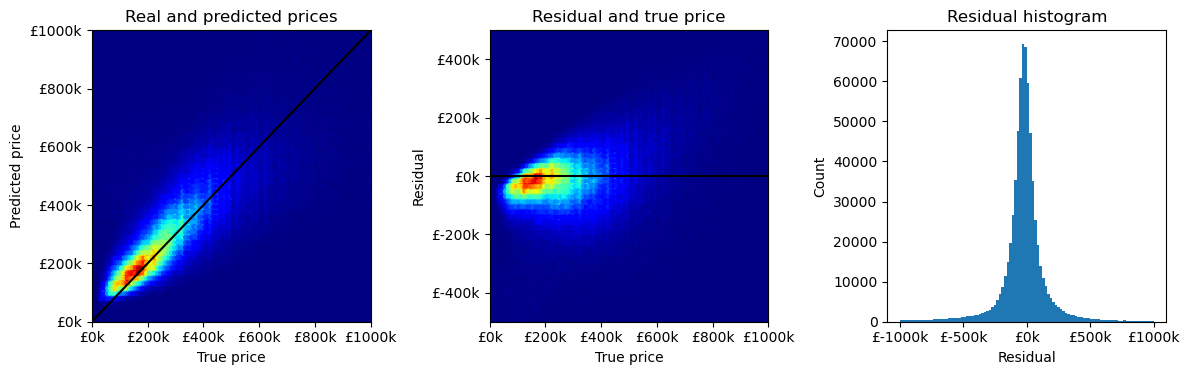

R² = 0.127


In [34]:
#Fit with updated features
important_features_1 = [
    'Tenure', 'latitude', 'longitude', 'gender_ratio', 'child_ratio',
     'elderly_ratio', 'commute_distance', 'Income', 'London_distance',
     'listings_per_capita', 'days_since_first', 'sine_day', 'cosine_day', 'Type_D',
     'Type_F', 'Type_S', 'Type_T'
]

model_2.fit(X_train[important_features_1], y_train)
y_validate_predict = model_2.predict(X_validate[important_features_1])
assess_predict(y_validate, y_validate_predict)

In [36]:
model_3 = clone(grad_boost_model_pipeline)

#Now tuning the other important hyperparameters
param_grid_3 = {
    'regressor__regressor__learning_rate': [0.05, 0.1, 0.5],
    'regressor__regressor__max_iter': [200, 500,1000],
    'regressor__regressor__max_depth': [5, 7, 10, None],
    'regressor__regressor__min_samples_leaf': [20, 50, 100],
    'regressor__regressor__l2_regularization': [0, 1, 5],
    'regressor__log_transform__log_income': [True, False],
    'regressor__log_transform__log_listings': [True, False],
    'transformer__log_target': [True, False],
}

random_search = RandomizedSearchCV(
    model_3,
    param_grid_3,
    cv=3,
    scoring='r2',
    n_iter=300, #About 10% of sample space
    random_state=89,
    n_jobs=-1)

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('log_transform',
                                                                                   LogTransformer()),
                                                                                  ('scaler',
                                                                                   StandardScaler()),
                                                                                  ('regressor',
                                                                                   HistGradientBoostingRegressor(random_state=89))]),
                                                        transformer=ConditionalLogTransformer()),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'regressor__log_transform__log_income': [True,
                                                                                 False],
                                        'r...__log_listings': [True,
                                                                                   False],
                                        'regressor__regressor__l2_regularization': [0,
                                                                                    1,
                                                                                    5],
                                        'regressor__regressor__learning_rate': [0.05,
                                                                                0.1,
                                                                                0.5],
                                        'regressor__regressor__max_depth': [5,
                                                                            7,
                                                                            10,
                                                                            None],
                                        'regressor__regressor__max_iter': [200,
                                                                           500,
                                                                           1000],
                                        'regressor__regressor__min_samples_leaf': [20,
                                                                                   50,
                                                                                   100],
                                        'transformer__log_target': [True,
                                                                    False]},
                   random_state=89, scoring='r2')

In [37]:
print("Best parameters:", random_search.best_params_)

Best parameters: {'transformer__log_target': False, 'regressor__regressor__min_samples_leaf': 20, 'regressor__regressor__max_iter': 1000, 'regressor__regressor__max_depth': None, 'regressor__regressor__learning_rate': 0.1, 'regressor__regressor__l2_regularization': 1, 'regressor__log_transform__log_listings': True, 'regressor__log_transform__log_income': False}


D-2. Selecting features 2

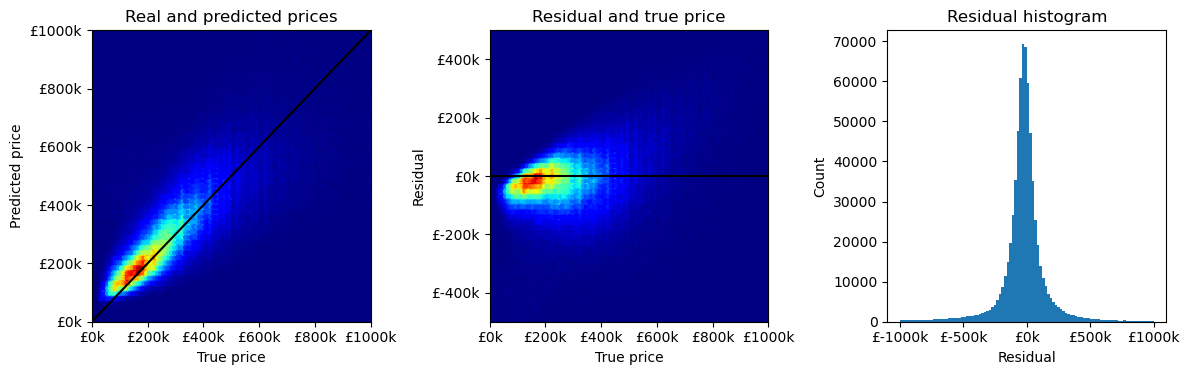

R² = 0.127


In [41]:
#fit with updated hyperparameters
model_4 = clone(grad_boost_model_pipeline).set_params(
    regressor__regressor__max_iter=1000,
    regressor__regressor__learning_rate=0.1,
    regressor__regressor__l2_regularization=1,
    regressor__log_transform__log_listings=True
)

model_4.fit(X_train[important_features_1], y_train)
y_validate_predict = model_4.predict(X_validate[important_features_1])
assess_predict(y_validate, y_validate_predict)

In [42]:
feature_importance = feature_importance_test(model_4, X_train, y_train, X_validate, y_validate)

r2 = 0.124, change = 0.000
features: ['New' 'Tenure' 'latitude' 'longitude' 'gender_ratio' 'child_ratio'
 'elderly_ratio' 'commute_distance' 'Income' 'Eng_Wal' 'London_distance'
 'listings_per_capita' 'days_since_first' 'sine_day' 'cosine_day' 'Type_D'
 'Type_F' 'Type_S' 'Type_T']
least important feature: Eng_Wal

r2 = 0.124, change = -0.000
features: ['New' 'Tenure' 'latitude' 'longitude' 'gender_ratio' 'child_ratio'
 'elderly_ratio' 'commute_distance' 'Income' 'London_distance'
 'listings_per_capita' 'days_since_first' 'sine_day' 'cosine_day' 'Type_D'
 'Type_F' 'Type_S' 'Type_T']
least important feature: New

r2 = 0.127, change = -0.003
features: ['Tenure' 'latitude' 'longitude' 'gender_ratio' 'child_ratio'
 'elderly_ratio' 'commute_distance' 'Income' 'London_distance'
 'listings_per_capita' 'days_since_first' 'sine_day' 'cosine_day' 'Type_D'
 'Type_F' 'Type_S' 'Type_T']
least important feature: Type_D

r2 = 0.111, change = 0.016
features: ['Tenure' 'latitude' 'longitude' 'gender_rat

In [43]:
feature_importance

,least_important_feature,r2,r2_change
0,Eng_Wal,0.123649,0.000000
1,New,0.123849,-0.000200
2,Type_D,0.127153,-0.003304
3,Type_S,0.111015,0.016138
4,longitude,0.099971,0.011043
5,Type_T,0.096439,0.003533
6,days_since_first,0.087177,0.009261
7,elderly_ratio,0.088540,-0.001362
8,Tenure,0.084592,0.003948
9,latitude,0.075233,0.009360


In [44]:
#Exact same featrure combination as with previous hyperparameters.
#Convergance reached.

E. Training final model and saving output

In [68]:
#Prepare final model

#Optimised hyperparameters
grad_boost_model_final = clone(grad_boost_model_pipeline).set_params(
    regressor__regressor__max_iter=1000,
    regressor__regressor__learning_rate=0.1,
    regressor__regressor__l2_regularization=1,
    regressor__log_transform__log_listings=True
)

#Optimised features
important_feautures_final = [
    'Tenure', 
    'latitude', 
    'longitude', 
    'gender_ratio', 
    'child_ratio',
    'elderly_ratio', 
    'commute_distance', 
    'Income', 
    'London_distance',
    'listings_per_capita', 
    'days_since_first', 
    'sine_day', 
    'cosine_day', 
    'Type_D',
    'Type_F', 
    'Type_S', 
    'Type_T'
]

In [69]:
grad_boost_model_final.fit(X_train_all[important_feautures_final], y_train_all)

TransformedTargetRegressor(regressor=Pipeline(steps=[('log_transform',
                                                      LogTransformer(log_listings=True)),
                                                     ('scaler',
                                                      StandardScaler()),
                                                     ('regressor',
                                                      HistGradientBoostingRegressor(l2_regularization=1,
                                                                                    max_iter=1000,
                                                                                    random_state=89))]),
                           transformer=ConditionalLogTransformer())

In [70]:
#Fetch test data
raw_test_df = pd.read_csv('test_house_final.csv')

#Numerically encode categorical features
test_df_encode = encode_categories(raw_test_df)

#Split test dataset into X (features) and y (targets)
X_test = test_df_encode.drop('Price', axis=1)
y_test = test_df_encode['Price']

X_test.shape, y_test.shape

((523267, 19), (523267,))

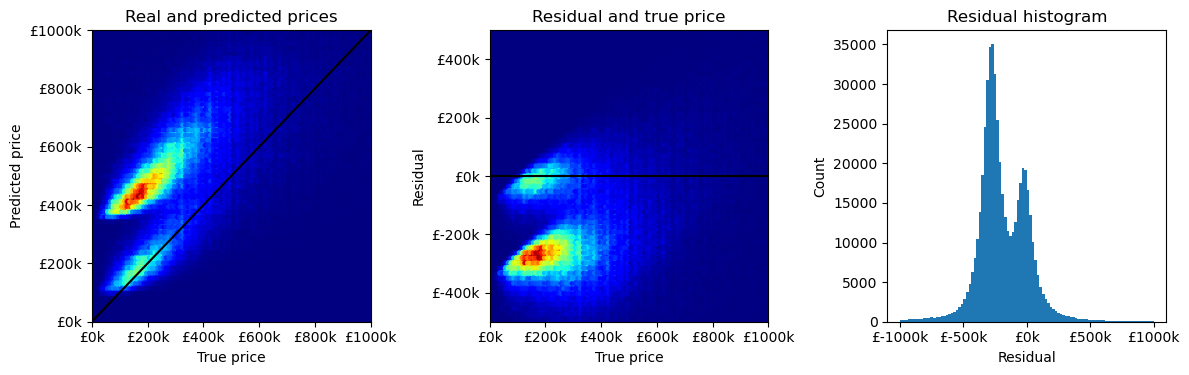

R² = 0.063


In [76]:
#Predict prices of test data
y_test_pred_final = grad_boost_model_final.predict(X_test[important_feautures_final])

#Check fit
assess_predict(y_test, y_test_pred_final)

In [78]:
#??? Can't find any bugs in the code. Is this a problem with the model?
#Playing around, this is fixed if the learning rate is lowered (see below)
#I could reoptimise and try to fix this, but since I've already seen the fit, I would have biases so this would not be fair.
#I will save this data and will continue with the results from the other models

In [79]:
#Save final fit to csv
final_fit = pd.DataFrame({
    'True_Price': y_test,
    'GradientrBoost_Prediction': y_test_pred_final
})
final_fit.to_csv('test_results\\gradboost_model.csv', index_label='Index', float_format='%.2f')

F. Refitting test data with smaller learning rate hyperparameter

In [72]:
#PSame model as before, but learning rate 0.1 --> 0.001

#Optimised hyperparameters
grad_boost_model_low_learn_rate = clone(grad_boost_model_pipeline).set_params(
    regressor__regressor__max_iter=1000,
    regressor__regressor__learning_rate=0.001,
    regressor__regressor__l2_regularization=1,
    regressor__log_transform__log_listings=True
)

In [73]:
grad_boost_model_low_learn_rate.fit(X_train_all[important_feautures_final], y_train_all)

TransformedTargetRegressor(regressor=Pipeline(steps=[('log_transform',
                                                      LogTransformer(log_listings=True)),
                                                     ('scaler',
                                                      StandardScaler()),
                                                     ('regressor',
                                                      HistGradientBoostingRegressor(l2_regularization=1,
                                                                                    learning_rate=0.001,
                                                                                    max_iter=1000,
                                                                                    random_state=89))]),
                           transformer=ConditionalLogTransformer())

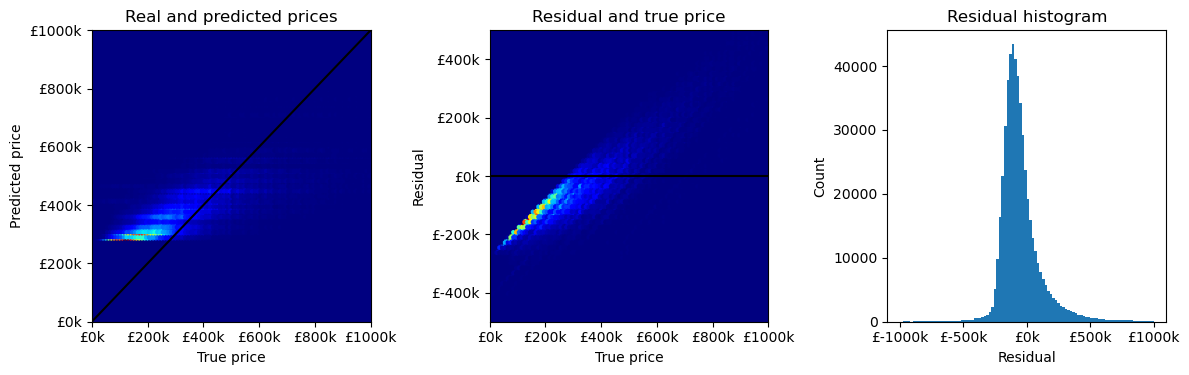

R² = 0.055


In [75]:
#Predict prices of test data
y_test_pred_final = grad_boost_model_low_learn_rate.predict(X_test[important_feautures_final])

#Check fit
assess_predict(y_test, y_test_pred_final)